In [1]:
from denovo_utils.parsers.converters import SpectralisParser, DenovoEngineConverter
import pandas as pd
import os

from matplotlib import pyplot as plt
import seaborn as sns

from psm_utils import PSM, PSMList
from tqdm import tqdm
from denovo_utils.analysis.mixture_models import assign_ggm_clusters, plot_cluster_psmtype, get_ggm_n_clusters

from denovo_utils.analysis.evaluation import get_precision_coverage_df

import warnings
warnings.filterwarnings("ignore")

Modification already exists in ModificationsDB. Skipping.


2024-09-11 12:36:52.127125: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-11 12:36:52.127158: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-11 12:36:52.127935: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Calculate classic metrics:

Look at Wout Bittremieux paper
- Recall
- Precision
- Coverage
- Precision-coverage curves
- Both on amino acid and peptide level
- Levenshtein metrics

# 0. Load data

Filter so only the spectra are considered which are confident hits

In [2]:
df = pd.read_pickle("F06_merged.pkl")

df_db = df[df["source"]=="sage"]
spectra_selection = df_db.loc[df_db["psm_type"]=="target_accepted", "spectrum_id"].tolist()

In [3]:
len(spectra_selection)

40270

In [4]:
df = df[df["spectrum_id"].isin(spectra_selection)]

In [5]:
ground_truth = df_db.loc[df_db["psm_type"]=="target_accepted", ["peptide", "spectrum_id"]].set_index("spectrum_id").to_dict("index")

def evaluate_prediction(row, ground_truth):
    ground_truth_peptidoform = ground_truth[row["spectrum_id"]]["peptide"]
    if isinstance(ground_truth_peptidoform, type(None)):
        return None
    return ground_truth_peptidoform == row["peptide"]

df["correct_prediction"] = df.apply(lambda x: evaluate_prediction(x, ground_truth), axis=1)

# 1. Recall

In [6]:
df.source.value_counts()

source
PepNet           40270
sage             40270
InstaNovo        40239
Novor            40224
Casanovo4.2.0    40214
NovoB            39800
PepNovo+         33828
ContraNovo       20295
Name: count, dtype: int64

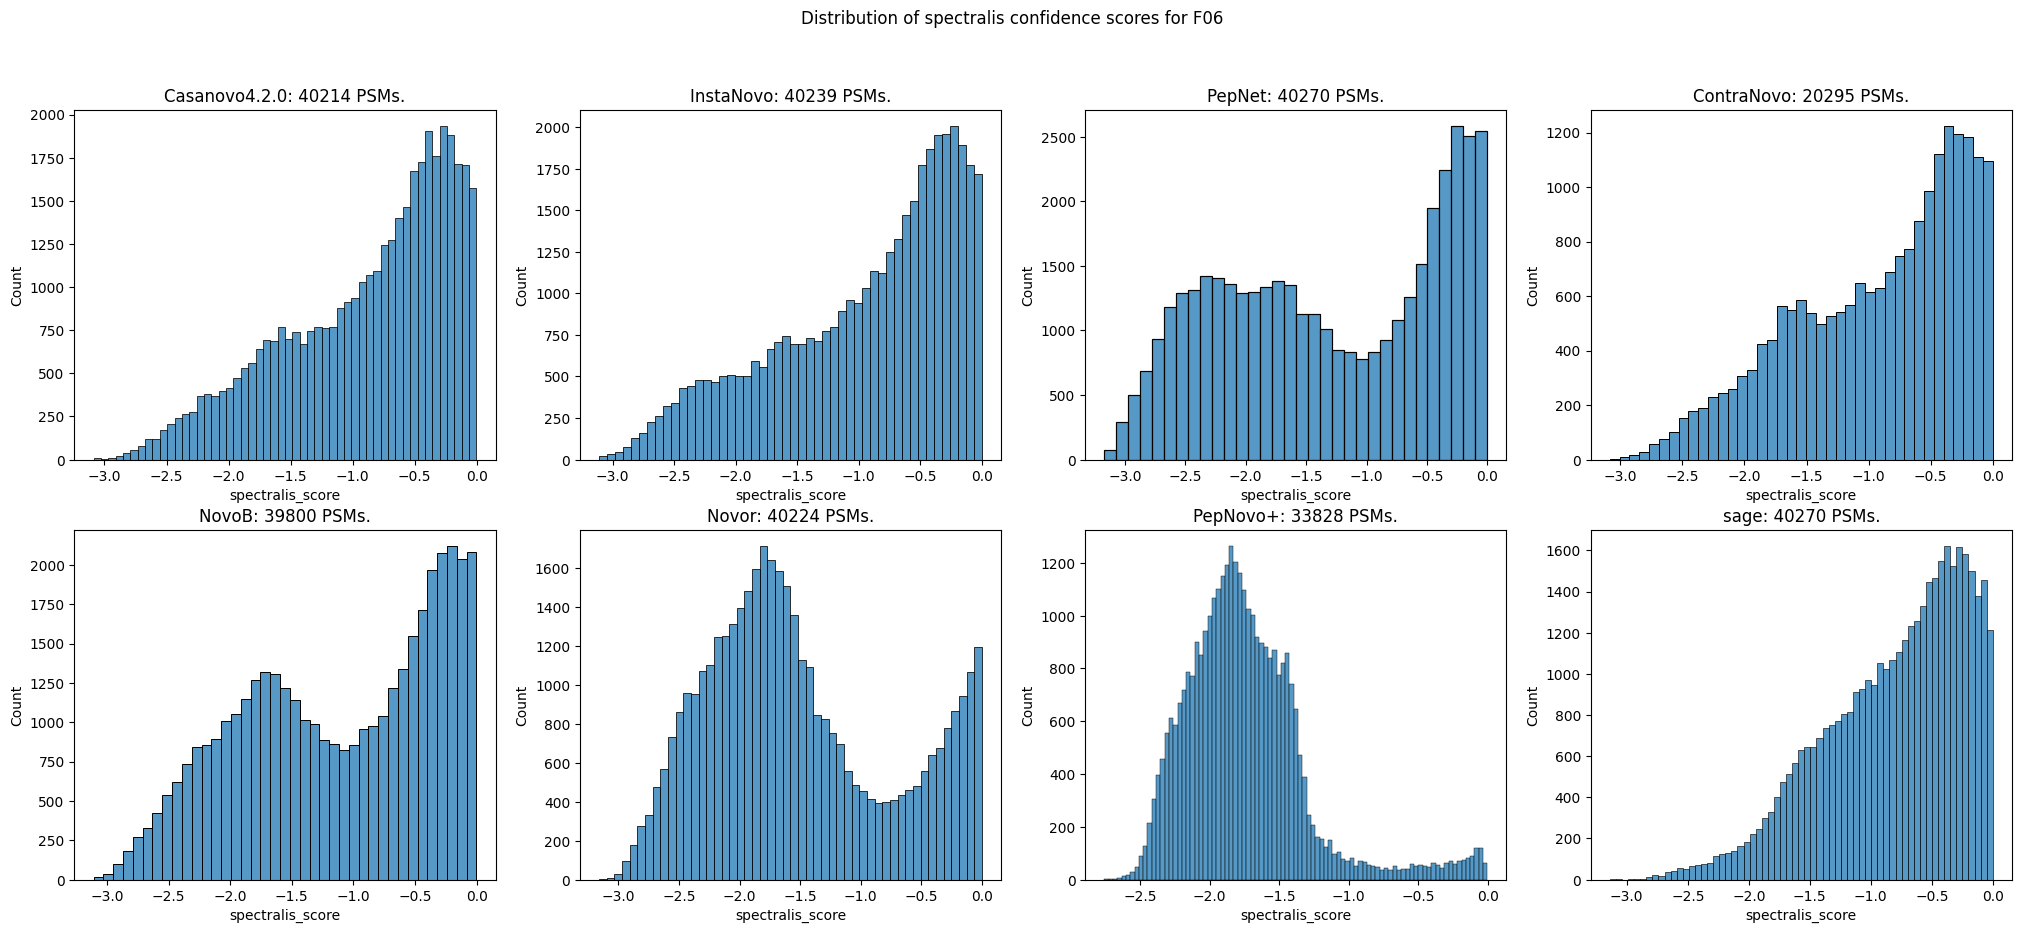

In [27]:
fig, ax = plt.subplots(2,4, figsize=(25,10))

x=0

fig.suptitle("Distribution of spectralis confidence scores for F06")
for y, engine in enumerate(df.source.unique()):
    if y >= 4:
        x=1
        y-=4
    selection = df[
        df.source==engine
    ]
    sns.histplot(
        selection["spectralis_score"],
        ax=ax[x][y]
    )
    ax[x][y].set_title(f"{engine}: {len(selection)} PSMs.")

In [19]:
evaluation = df.groupby("source")["correct_prediction"].value_counts()
evaluation.name="count"
evaluation = evaluation.reset_index()

<Axes: xlabel='count', ylabel='source'>

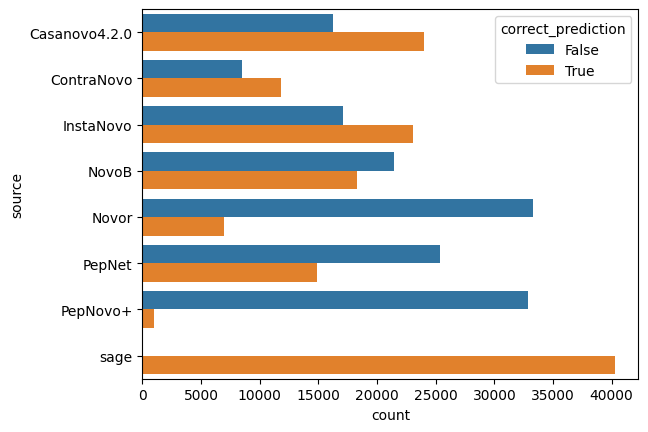

In [20]:
sns.barplot(
    evaluation,
    y="source",
    hue="correct_prediction",
    x="count"
)

<Axes: xlabel='count', ylabel='source'>

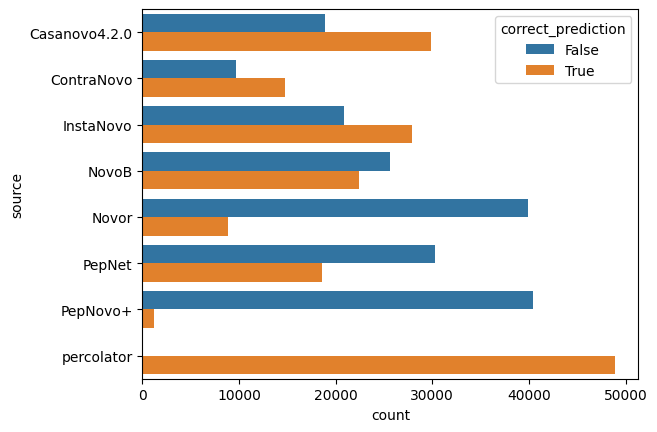

In [11]:
sns.barplot(
    evaluation,
    y="source",
    hue="correct_prediction",
    x="count"
)

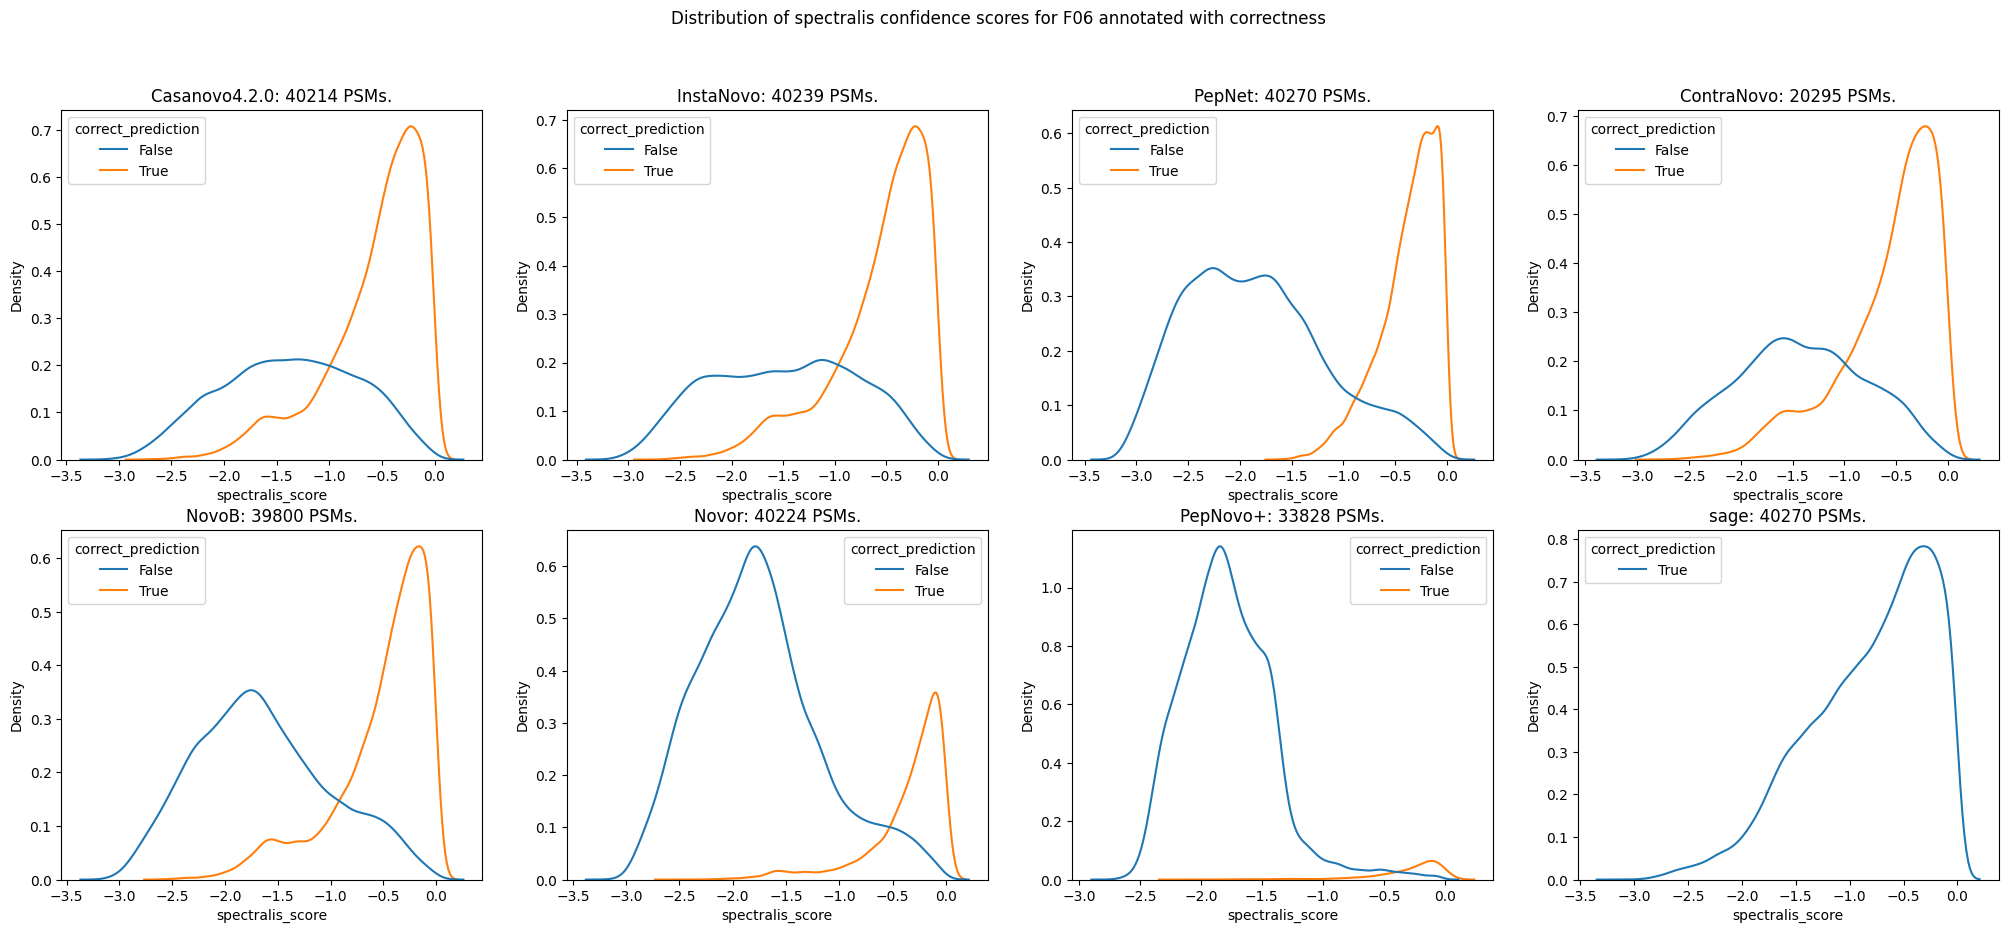

In [28]:
fig, ax = plt.subplots(2,4, figsize=(25,10))

x=0

fig.suptitle("Distribution of spectralis confidence scores for F06 annotated with correctness")
for y, engine in enumerate(df.source.unique()):
    if y >= 4:
        x=1
        y-=4
    selection = df[
        df.source==engine
    ]
    sns.kdeplot(
        selection,
        x="spectralis_score",
        hue="correct_prediction",
        ax=ax[x][y]
    )
    ax[x][y].set_title(f"{engine}: {len(selection)} PSMs.")

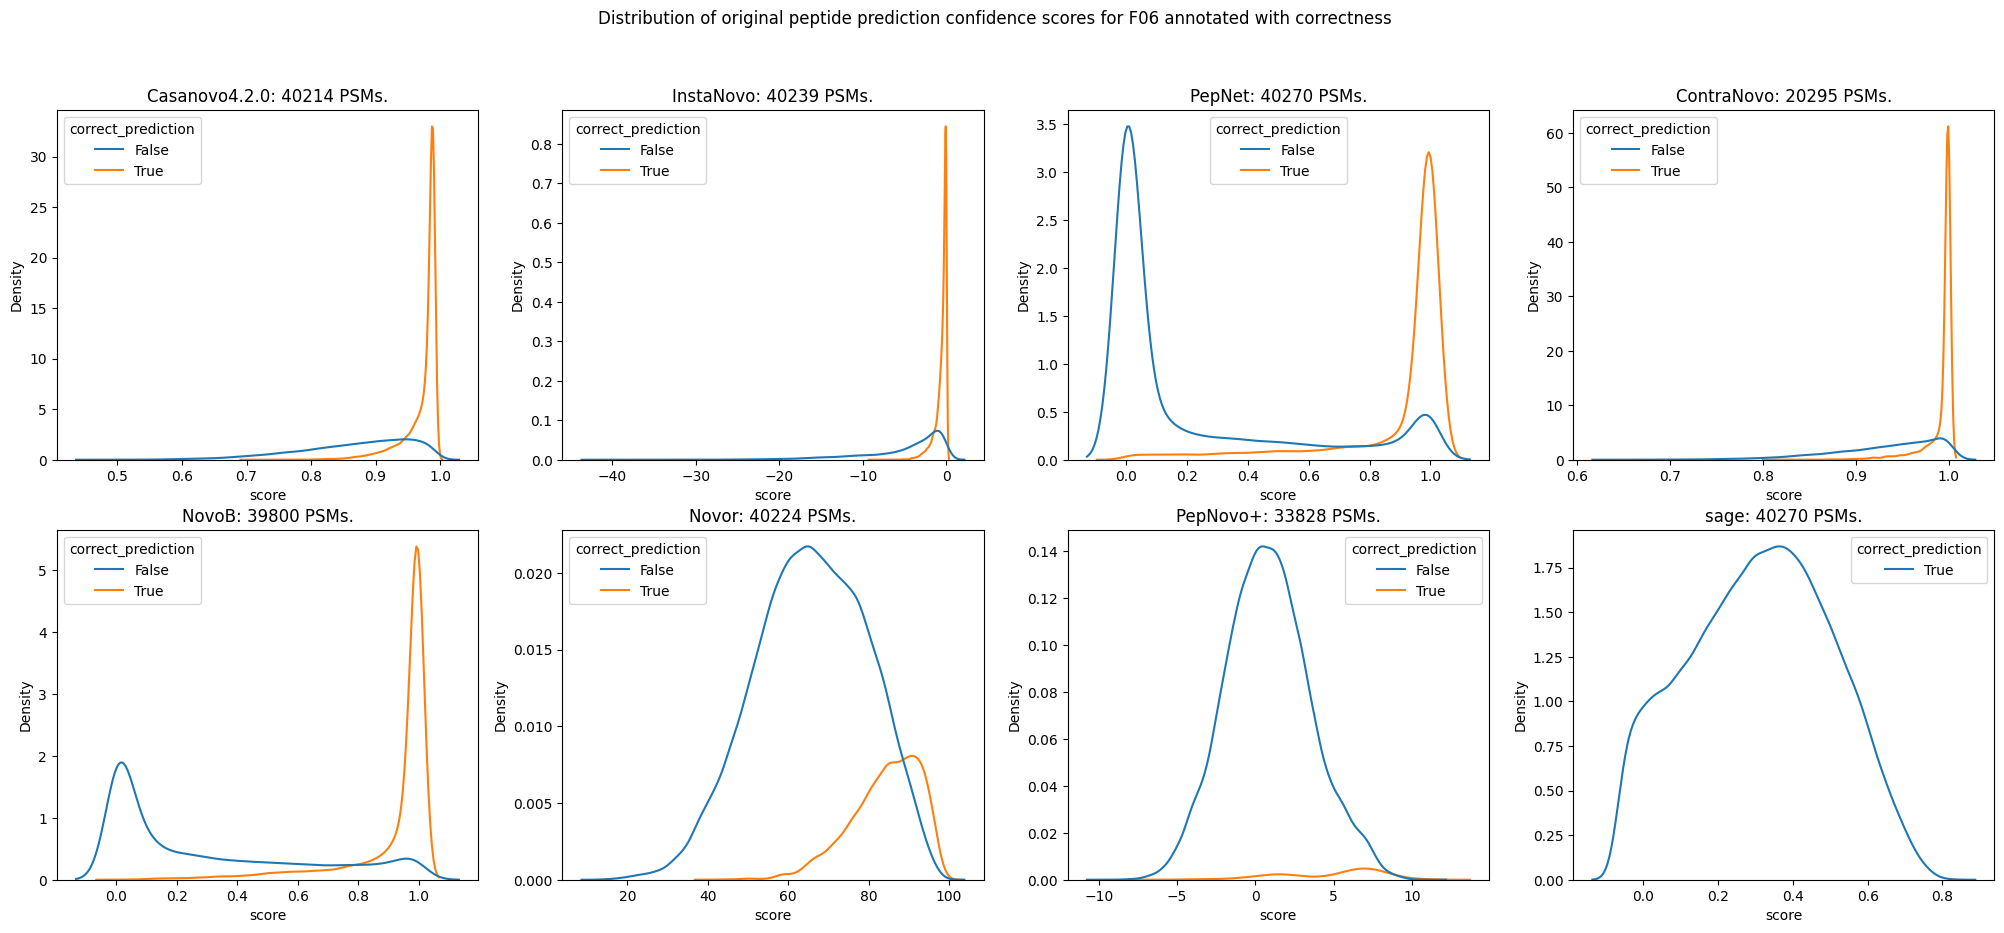

In [26]:
fig, ax = plt.subplots(2,4, figsize=(25,10))

x=0

fig.suptitle("Distribution of original peptide prediction confidence scores for F06 annotated with correctness")
for y, engine in enumerate(df.source.unique()):
    if y >= 4:
        x=1
        y-=4
    selection = df[
        df.source==engine
    ]
    sns.kdeplot(
        selection,
        x="score",
        hue="correct_prediction",
        ax=ax[x][y],
    )
    ax[x][y].set_title(f"{engine}: {len(selection)} PSMs.")

# 2. Precision-coverage curves


With the original scores

In [ ]:
fig, ax = plt.subplots(2,4, figsize=(25,10))

x=0

fig.suptitle("Distribution of spectralis confidence scores for F06 annotated with correctness")
for y, engine in enumerate(df.source.unique()):
    if y >= 4:
        x=1
        y-=4
    selection = df[
        df.source==engine
    ]
    sns.kdeplot(
        selection,
        x="spectralis_score",
        hue="correct_prediction",
        ax=ax[x][y]
    )
    ax[x][y].set_title(f"{engine}: {len(selection)} PSMs.")

In [8]:
df.columns

Index(['peptidoform', 'spectrum_id', 'run', 'collection', 'spectrum',
       'is_decoy', 'score', 'qvalue', 'pep', 'precursor_mz', 'retention_time',
       'ion_mobility', 'protein_list', 'rank', 'source', 'provenance_data',
       'metadata', 'rescoring_features', 'spectralis_score', 'psm_type',
       'peptide', 'correct_prediction'],
      dtype='object')

In [18]:
engine

'sage'

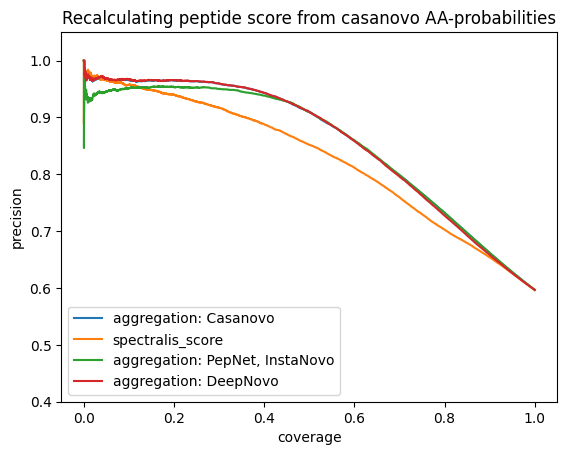

In [33]:
import numpy as np

df_casanovo = df.loc[df.source.isin(["Casanovo4.2.0", "sage"]), :]

def casanovo_to_instanovo_aggregation(row):
    try:
        peptide_score = row["score"]
        aa_scores = [np.log(float(x)*2-peptide_score) for x in row["metadata"]["aa_scores"].split(',')]
        return np.sum(aa_scores)
    except:
        return None

def casanovo_to_pepnet_aggregation(row):
    try:
        peptide_score = row["score"]
        aa_scores = [float(x)*2-peptide_score for x in row["metadata"]["aa_scores"].split(',')]
        return np.prod(aa_scores)
    except:
        return None

def casanovo_to_deepnovo_aggregation(row):
    try:
        peptide_score = row["score"]
        aa_scores = [np.log(float(x)*2-peptide_score) for x in row["metadata"]["aa_scores"].split(',')]
        return np.sum(aa_scores) / len(row["peptidoform"])
    except:
        return None
    
def casanovo_to_casanovo_aggregation(row):
    try:
        peptide_score = row["score"]
        aa_scores = [float(x)*2-peptide_score for x in row["metadata"]["aa_scores"].split(',')]
        return np.mean(aa_scores)
    except:
        return None
    

df_casanovo["aggregation: PepNet, InstaNovo"] = df_casanovo.apply(lambda x: casanovo_to_pepnet_aggregation(x), axis=1)
df_casanovo["aggregation: DeepNovo"] = df_casanovo.apply(lambda x: casanovo_to_deepnovo_aggregation(x), axis=1)
df_casanovo["aggregation: Casanovo"] = df_casanovo.apply(lambda x: casanovo_to_casanovo_aggregation(x), axis=1)

for score_type in ["aggregation: Casanovo", "spectralis_score", "aggregation: PepNet, InstaNovo", "aggregation: DeepNovo"]:
    metrics_score = get_precision_coverage_df(
        df_casanovo,
        source="Casanovo4.2.0",
        score_col=score_type,
        correctness_col="correct_prediction",
        ground_truth_source="sage",
    )
    sns.lineplot(
        metrics_score,
        x="coverage",
        y="precision",
        label=score_type,
    )
    plt.ylim((.4, 1.05))
    plt.title("Recalculating peptide score from casanovo AA-probabilities")

In [30]:

df_pepnet = df.loc[df.source.isin(["PepNet", "sage"]), :]


In [44]:
eval(df_pepnet.metadata.iloc[0]["positional_scores"])

[0.99998033,
 1.0,
 0.95291406,
 0.2977507,
 0.343917,
 0.37276697,
 0.2234391,
 0.78294927,
 0.94840777,
 0.963152,
 0.96903944]

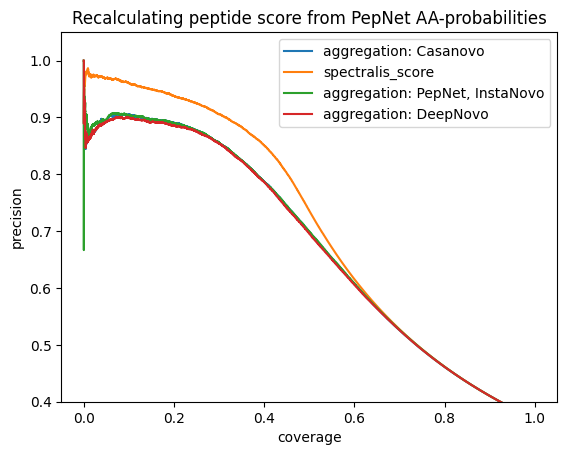

In [45]:
import numpy as np

df_pepnet = df.loc[df.source.isin(["PepNet", "sage"]), :]

def pepnet_to_instanovo_aggregation(row):
    try:
        peptide_score = row["score"]
        aa_scores = [np.log(float(x)) for x in eval(row["metadata"]["positional_scores"])]
        return np.sum(aa_scores)
    except:
        return None

def pepnet_to_pepnet_aggregation(row):
    try:
        peptide_score = row["score"]
        aa_scores = [float(x) for x in eval(row["metadata"]["positional_scores"])]
        return np.prod(aa_scores)
    except Exception as err:
        return None

def pepnet_to_deepnovo_aggregation(row):
    try:
        peptide_score = row["score"]
        aa_scores = [np.log(float(x)) for x in eval(row["metadata"]["positional_scores"])]
        return np.sum(aa_scores) / len(row["peptidoform"])
    except:
        return None
    
def pepnet_to_casanovo_aggregation(row):
    try:
        peptide_score = row["score"]
        aa_scores = [(float(x)+peptide_score)/2 for x in eval(row["metadata"]["positional_scores"])]
        return np.mean(aa_scores)
    except:
        return None
    

df_pepnet["aggregation: PepNet, InstaNovo"] = df_pepnet.apply(lambda x: pepnet_to_pepnet_aggregation(x), axis=1)
df_pepnet["aggregation: DeepNovo"] = df_pepnet.apply(lambda x: pepnet_to_deepnovo_aggregation(x), axis=1)
df_pepnet["aggregation: Casanovo"] = df_pepnet.apply(lambda x: pepnet_to_casanovo_aggregation(x), axis=1)

for score_type in ["aggregation: Casanovo", "spectralis_score", "aggregation: PepNet, InstaNovo", "aggregation: DeepNovo"]:
    metrics_score = get_precision_coverage_df(
        df_pepnet,
        source="PepNet",
        score_col=score_type,
        correctness_col="correct_prediction",
        ground_truth_source="sage",
    )
    sns.lineplot(
        metrics_score,
        x="coverage",
        y="precision",
        label=score_type,
    )
    plt.ylim((.4, 1.05))
    plt.title("Recalculating peptide score from PepNet AA-probabilities")

<Axes: xlabel='aggregation: DeepNovo', ylabel='aggregation: Casanovo'>

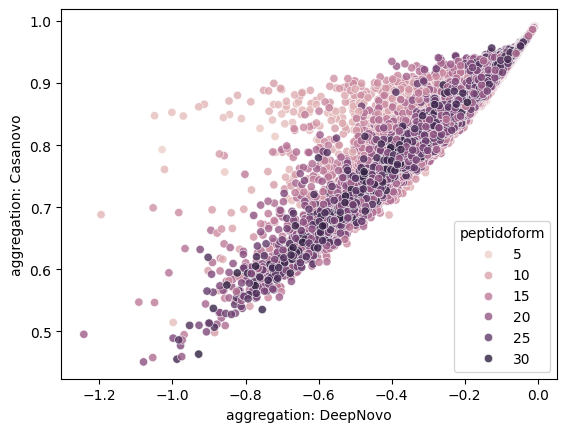

In [80]:
sns.scatterplot(
    df_casanovo[df_casanovo.source=="Casanovo4.2.0"],
    x="aggregation: DeepNovo",
    y="aggregation: Casanovo",
    hue=df_casanovo["peptidoform"].apply(lambda x: len(x)),
    alpha=.8
)

<Axes: xlabel='aggregation: DeepNovo', ylabel='aggregation: Casanovo'>

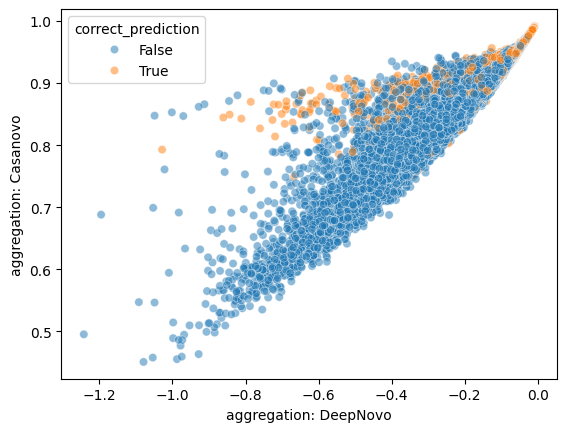

In [78]:
sns.scatterplot(
    df_casanovo[df_casanovo.source=="Casanovo4.2.0"],
    x="aggregation: DeepNovo",
    y="aggregation: Casanovo",
    hue=df_casanovo["peptidoform"].apply(lambda x: len(x)),
    alpha=.5
)

<Axes: xlabel='aggregation: PepNet, InstaNovo', ylabel='aggregation: Casanovo'>

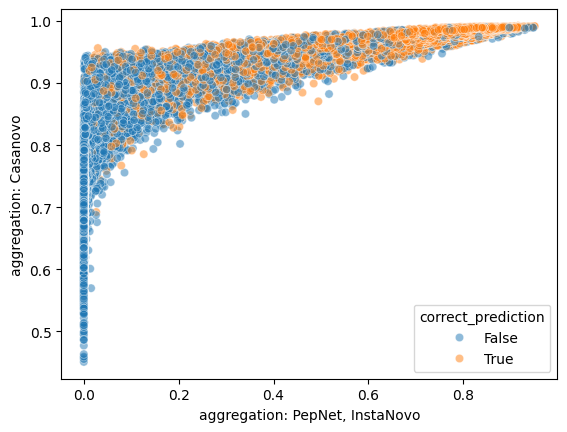

In [82]:
sns.scatterplot(
    df_casanovo[df_casanovo.source=="Casanovo4.2.0"],
    x="aggregation: PepNet, InstaNovo",
    y="aggregation: Casanovo",
    hue="correct_prediction",
    alpha=.5
)

<Axes: xlabel='aggregation: DeepNovo', ylabel='aggregation: PepNet, InstaNovo'>

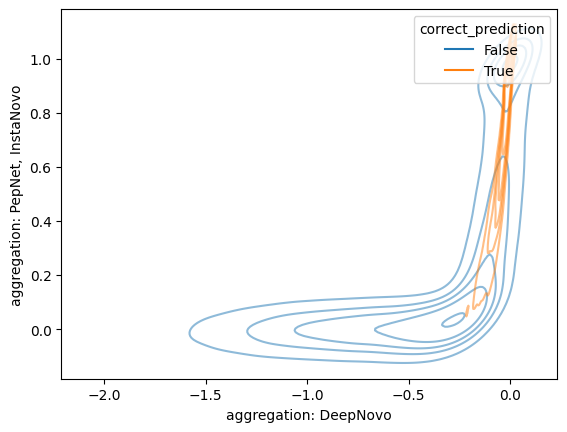

In [63]:
sns.kdeplot(
    df_pepnet[df_pepnet.source=="PepNet"],
    x="aggregation: DeepNovo",
    y="aggregation: PepNet, InstaNovo",
    hue=df_pepnet.correct_prediction,
    alpha=.5
)

<Axes: xlabel='spectralis_score', ylabel='Density'>

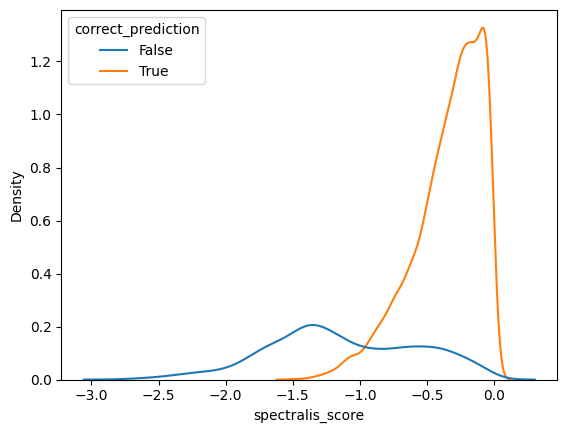

In [72]:
sns.kdeplot(
    df_pepnet[df_pepnet["aggregation: DeepNovo"]>-.05].sort_values("aggregation: PepNet, InstaNovo"),
    x="spectralis_score",
    hue="correct_prediction"
)

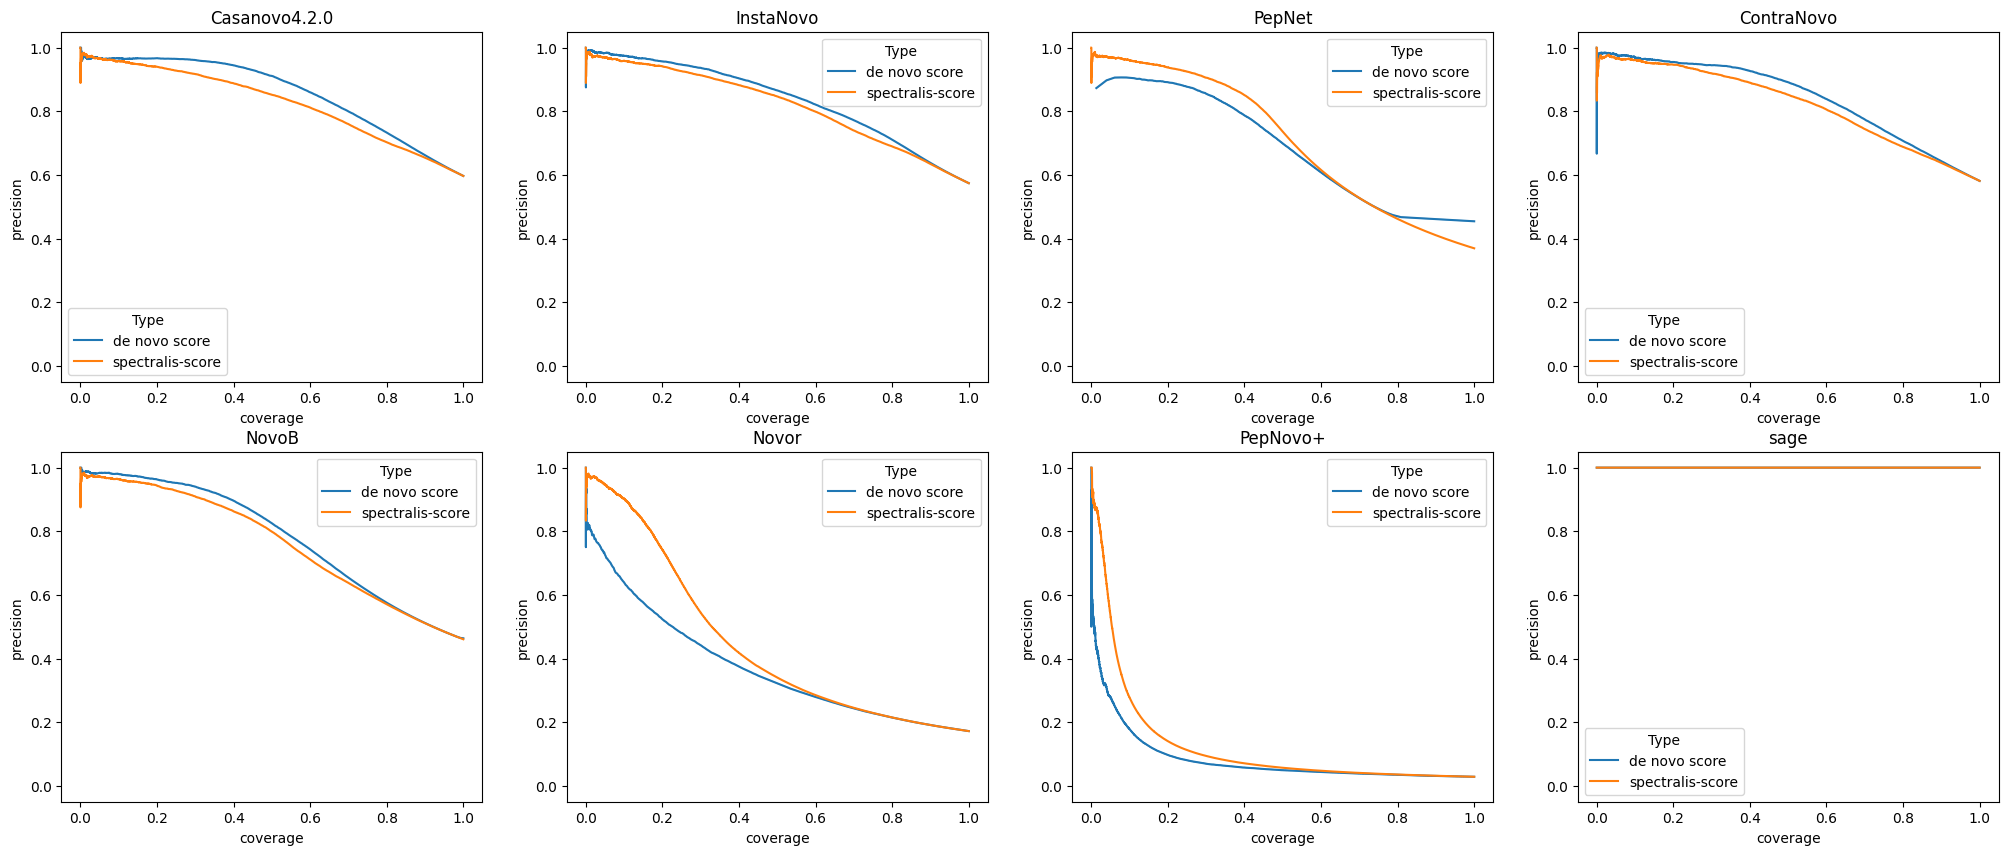

In [9]:
fig, ax = plt.subplots(2,4, figsize=(25,10))
x=0

metrics = {}
for y, engine in enumerate(df.source.unique()):
    if y>= 4:
        x=1
        y-=4

    metrics_score = get_precision_coverage_df(
        df,
        source=engine,
        score_col="score",
        correctness_col="correct_prediction",
        ground_truth_source="sage",
    )
    metrics_spectralis = get_precision_coverage_df(
        df,
        source=engine,
        score_col="spectralis_score",
        correctness_col="correct_prediction",
        ground_truth_source="sage",
    )

    sns.lineplot(
        metrics_score,
        x="coverage",
        y="precision",
        label="de novo score",
        ax=ax[x][y]
    )
    sns.lineplot(
        metrics_spectralis,
        x="coverage",
        y="precision",
        label="spectralis-score",
        ax=ax[x][y]
    )

    metrics[engine] = {
        "denovo": metrics_score,
        "spectralis": metrics_spectralis
    }

    ax[x][y].set_ylim((-.05, 1.05))
    ax[x][y].set_xlim((-.05, 1.05))
    ax[x][y].legend(title="Type")
    ax[x][y].set_title(engine)

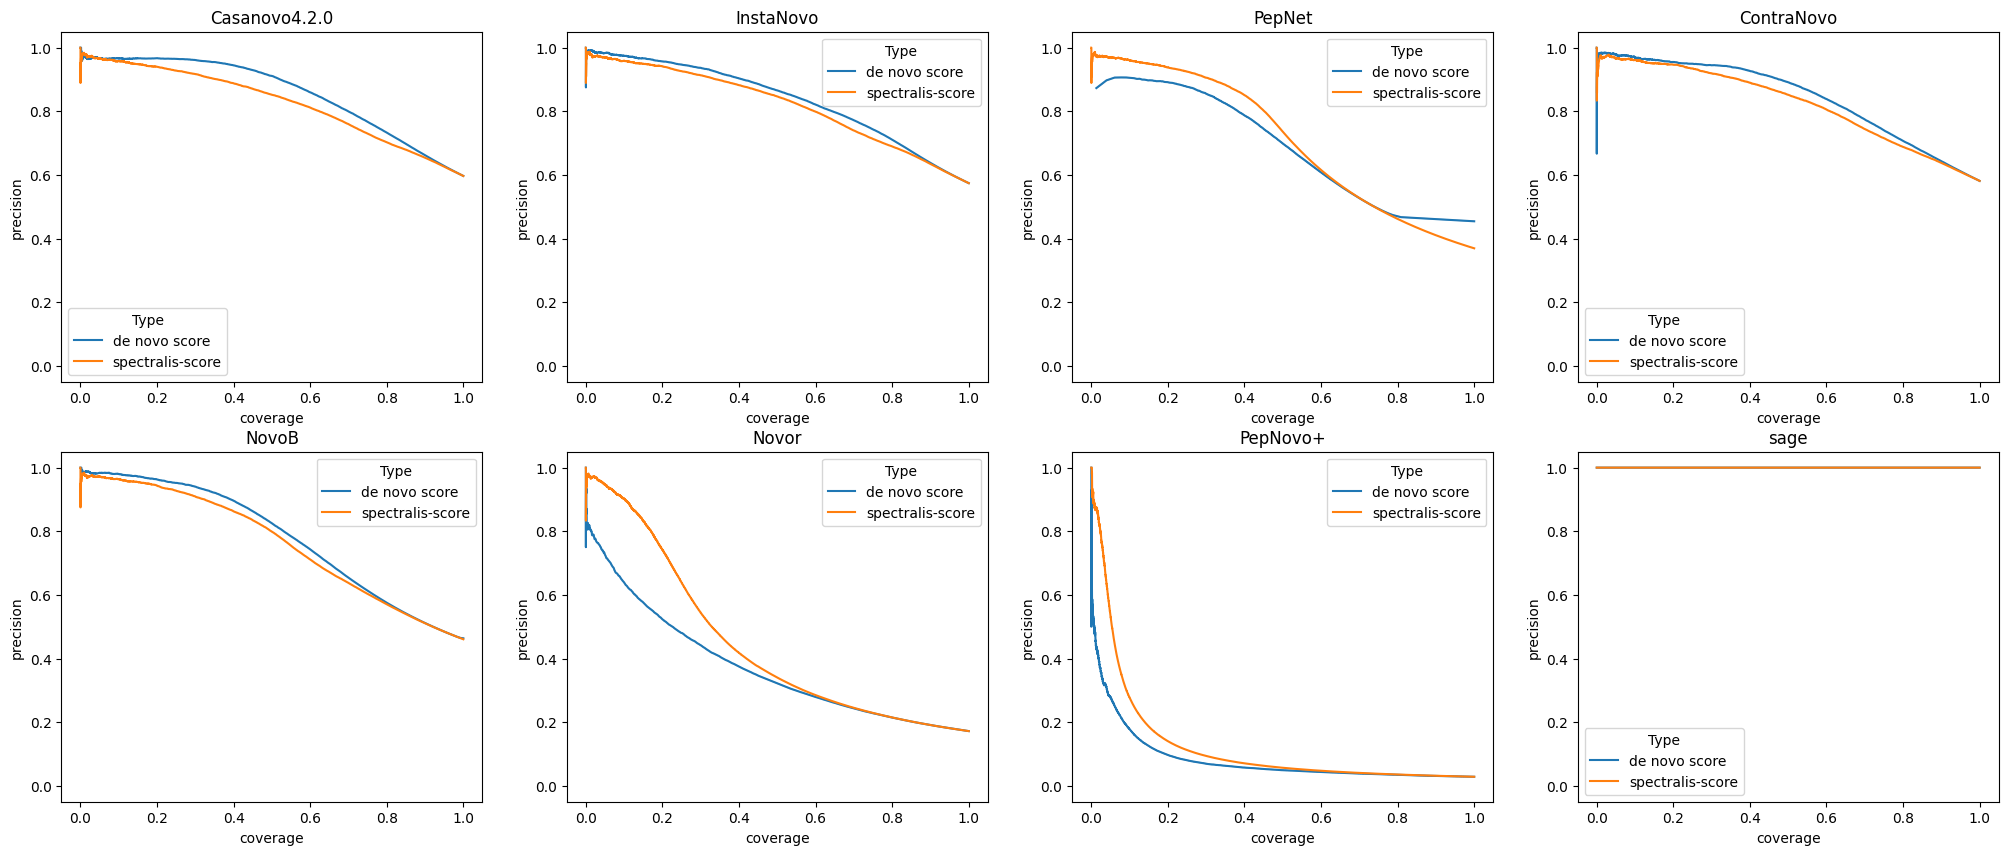

In [17]:
fig, ax = plt.subplots(2,4, figsize=(25,10))
x=0

metrics = {}
for y, engine in enumerate(df.source.unique()):
    if y>= 4:
        x=1
        y-=4

    metrics_score = get_precision_coverage_df(
        df,
        source=engine,
        score_col="score",
        ground_truth_source="sage",
    )
    metrics_spectralis = get_precision_coverage_df(
        df,
        source=engine,
        score_col="spectralis_score",
        ground_truth_source="sage",
    )

    sns.lineplot(
        metrics_score,
        x="coverage",
        y="precision",
        label="de novo score",
        ax=ax[x][y]
    )
    sns.lineplot(
        metrics_spectralis,
        x="coverage",
        y="precision",
        label="spectralis-score",
        ax=ax[x][y]
    )

    metrics[engine] = {
        "denovo": metrics_score,
        "spectralis": metrics_spectralis
    }

    ax[x][y].set_ylim((-.05, 1.05))
    ax[x][y].set_xlim((-.05, 1.05))
    ax[x][y].legend(title="Type")
    ax[x][y].set_title(engine)

In [20]:
metrics_df_spectralis = []
metrics_df_denovo = []
for engine, d in metrics.items():
    subset_spectralis = d["spectralis"]
    subset_spectralis["engine"] = engine
    subset = d["denovo"]
    subset["engine"] = engine

    metrics_df_spectralis.append(subset_spectralis)
    metrics_df_denovo.append(subset)

metrics_df_spectralis = pd.concat(metrics_df_spectralis)
metrics_df_denovo = pd.concat(metrics_df_denovo)

In [24]:
metrics_df_spectralis

,TP,FP,FN,U,U_mgf,precision,recall,coverage_mgf,coverage,engine
0,23996,16217,0,0,40270,0.596722,1.000000,0.499646,1.000000,Casanovo4.2.0
1,23996,16216,0,1,40269,0.596737,1.000000,0.499646,0.999975,Casanovo4.2.0
2,23996,16215,0,2,40268,0.596752,1.000000,0.499646,0.999950,Casanovo4.2.0
3,23996,16214,0,3,40267,0.596767,1.000000,0.499646,0.999925,Casanovo4.2.0
4,23996,16213,0,4,40266,0.596782,1.000000,0.499646,0.999901,Casanovo4.2.0
...,...,...,...,...,...,...,...,...,...,...
40264,5,0,40264,40264,6,1.000000,0.000124,0.454545,0.000124,sage
40265,4,0,40265,40265,5,1.000000,0.000099,0.444444,0.000099,sage
40266,3,0,40266,40266,4,1.000000,0.000074,0.428571,0.000074,sage
40267,2,0,40267,40267,3,1.000000,0.000050,0.400000,0.000050,sage


In [34]:
metrics_df_spectralis.engine.value_counts()

PepNet           40269
sage             40269
InstaNovo        40238
Novor            40223
Casanovo4.2.0    40213
NovoB            39799
PepNovo+         33827
ContraNovo       20294
Name: engine, dtype: int64

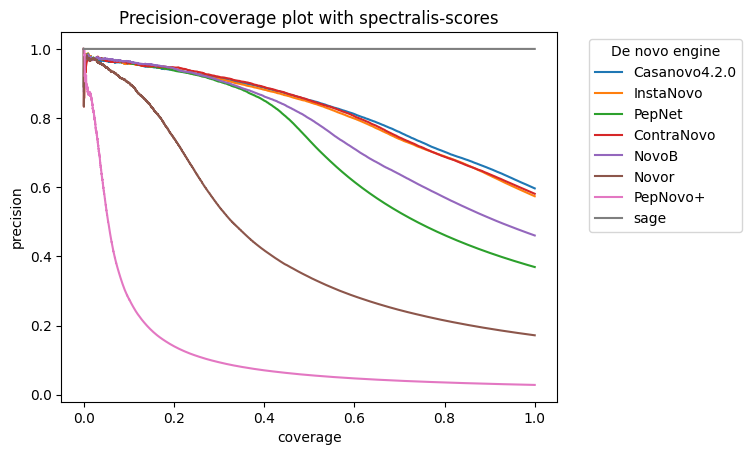

In [32]:
sns.lineplot(
    metrics_df_spectralis,
    x="coverage",
    y="precision",
    hue="engine"
)
plt.title("Precision-coverage plot with spectralis-scores")
plt.legend(title="De novo engine", bbox_to_anchor=(1.05, 1), loc='upper left')

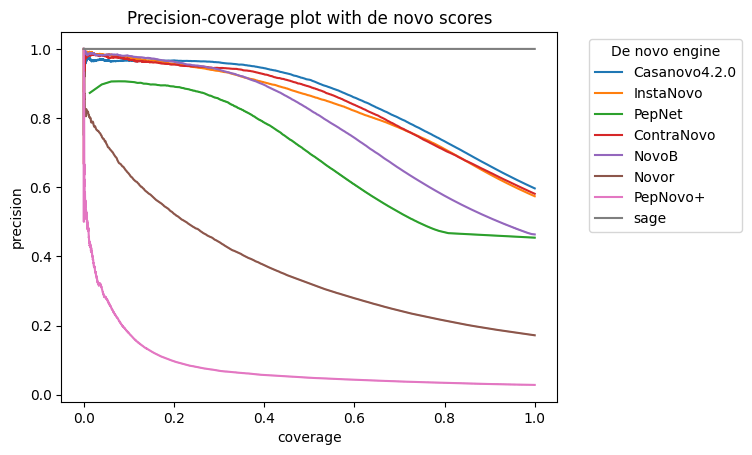

In [33]:
sns.lineplot(
    metrics_df_denovo,
    x="coverage",
    y="precision",
    hue="engine"
)
plt.title("Precision-coverage plot with de novo scores")
plt.legend(title="De novo engine", bbox_to_anchor=(1.05, 1), loc='upper left')

In [6]:
import numpy as np

np.prod([0.9427687, 0.9994192, 0.9866022, 0.5431996, 0.9301792, 0.9998728, 0.9997619, 0.99967134, 0.9939428, 0.9486753, 0.3671049, 0.9959998, 0.9948073, 0.9993912])

0.16088756140953955